In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
# print(os.listdir("../input"))
# Any results you write to the current directory are saved as output.

## Loading the data

In [ ]:
dtypes = {"crew": "int8",
          "experiment": "category",
          "time": "float32",
          "seat": "int8",
          "eeg_fp1": "float32",
          "eeg_f7": "float32",
          "eeg_f8": "float32",
          "eeg_t4": "float32",
          "eeg_t6": "float32",
          "eeg_t5": "float32",
          "eeg_t3": "float32",
          "eeg_fp2": "float32",
          "eeg_o1": "float32",
          "eeg_p3": "float32",
          "eeg_pz": "float32",
          "eeg_f3": "float32",
          "eeg_fz": "float32",
          "eeg_f4": "float32",
          "eeg_c4": "float32",
          "eeg_p4": "float32",
          "eeg_poz": "float32",
          "eeg_c3": "float32",
          "eeg_cz": "float32",
          "eeg_o2": "float32",
          "ecg": "float32",
          "r": "float32",
          "gsr": "float32",
          "event": "category",
         }

In [ ]:
train_df = pd.read_csv("../input/train.csv", dtype=dtypes)
test_df = pd.read_csv("../input/test.csv", dtype=dtypes)

In [ ]:
train_df.head()

## Normalization

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook as tqdm
# the tqdm is for showing the process

In [ ]:
features_n = ["eeg_fp1", "eeg_f7", "eeg_f8", "eeg_t4", "eeg_t6", "eeg_t5", "eeg_t3", "eeg_fp2", "eeg_o1", "eeg_p3", "eeg_pz", "eeg_f3", "eeg_fz", "eeg_f4", "eeg_c4", "eeg_p4", "eeg_poz", "eeg_c3", "eeg_cz", "eeg_o2", "ecg", "r", "gsr"]

In [ ]:
train_df['pilot'] = 100 * train_df['seat'] + train_df['crew']
test_df['pilot'] = 100 * test_df['seat'] + test_df['crew']

print("Number of pilots : ", len(train_df['pilot'].unique()))

In [ ]:
train_df['pilot'].unique()

In [ ]:
def normalize_by_pilots(df):
    pilots = df["pilot"].unique()
    for pilot in tqdm(pilots):
        ids = df[df["pilot"] == pilot].index
        scaler = MinMaxScaler()
        df.loc[ids, features_n] = scaler.fit_transform(df.loc[ids, features_n])        
    return df

In [ ]:
train_df = normalize_by_pilots(train_df)
test_df = normalize_by_pilots(test_df)

In [ ]:
test_df.head()

## Train/Test split

In [31]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb

In [ ]:
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=420)
print(f"Training on {train_df.shape[0]} samples.")

In [29]:
features = ["crew", "seat"] + features_n
      
def run_lgb(df_train, df_test):
    # Classes as integers
    dic = {'A': 0, 'B': 1, 'C': 2, 'D': 3}
    try:
        df_train["event"] = df_train["event"].apply(lambda x: dic[x])
        df_test["event"] = df_test["event"].apply(lambda x: dic[x])
    except: 
        pass
    params = {"objective" : "multiclass",
              "num_class": 4,
              "metric" : "multi_error",
              "num_leaves" : 30,
              "min_child_weight" : 50,
              "learning_rate" : 0.1,
              "bagging_fraction" : 0.7,
              "feature_fraction" : 0.7,
              "bagging_seed" : 420,
              "verbosity" : -1
             }
    
    lg_train = lgb.Dataset(df_train[features], label=(df_train["event"]))
    lg_test = lgb.Dataset(df_test[features], label=(df_test["event"]))
    model = lgb.train(params, lg_train, 1000, valid_sets=[lg_test], early_stopping_rounds=50, verbose_eval=100)
    
    return model

In [32]:
model = run_lgb(train_df, val_df)

Training until validation scores don't improve for 50 rounds.
[100]	valid_0's multi_error: 0.0821512
[200]	valid_0's multi_error: 0.068337
[300]	valid_0's multi_error: 0.0598006
[400]	valid_0's multi_error: 0.0539228
[500]	valid_0's multi_error: 0.0499443
[600]	valid_0's multi_error: 0.0467958
[700]	valid_0's multi_error: 0.044165
[800]	valid_0's multi_error: 0.0419852
[900]	valid_0's multi_error: 0.0399277
[1000]	valid_0's multi_error: 0.0383067
Did not meet early stopping. Best iteration is:
[1000]	valid_0's multi_error: 0.0383067


 ### Feature importance


In [42]:
from sklearn.metrics import confusion_matrix, log_loss
import matplotlib.pyplot as plt
import itertools

In [36]:
pred_val = model.predict(val_df[features], num_iteration=model.best_iteration)

In [37]:
print("Log loss on validation data :", round(log_loss(np.array(val_df["event"].values), pred_val), 3))

Log loss on validation data : 0.108


In [43]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', normalize=False, cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fmt = '.2f' if normalize else 'd'

    fig, ax = plt.subplots(figsize=(15, 10))
    ax.imshow(cm, interpolation='nearest', cmap=cmap)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size=15)
    plt.colorbar()
    plt.grid(False)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = (cm.max()+cm.min()) / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', size=12)
    plt.xlabel('Predicted label', size=12)

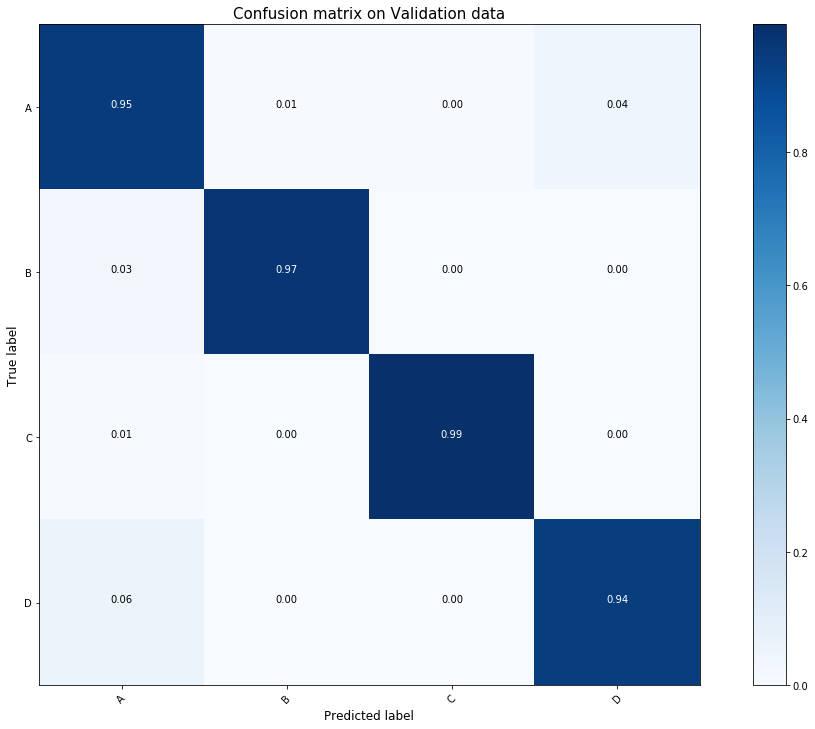

In [44]:
conf_mat_val = confusion_matrix(np.argmax(pred_val, axis=1), val_df["event"].values)
plot_confusion_matrix(conf_mat_val, ["A", "B", "C", "D"], title='Confusion matrix on Validation data', normalize=True)

## submission

In [45]:
pred_test = model.predict(test_df[features], num_iteration=model.best_iteration)

In [46]:
submission = pd.DataFrame(np.concatenate((np.arange(len(test_df))[:, np.newaxis], pred_test), axis=1), columns=['id', 'A', 'B', 'C', 'D'])
submission['id'] = submission['id'].astype(int)

In [47]:
submission.head()

,id,A,B,C,D
0,0,0.983302,0.007937,0.002576,0.006186
1,1,0.988025,0.000176,0.000929,0.010870
2,2,0.979629,0.006281,0.004426,0.009664
3,3,0.988181,0.000185,0.000976,0.010658
4,4,0.984778,0.005659,0.004741,0.004822


In [48]:
submission.to_csv("submission.csv", index=False)